This file contains the methods to test the different trained networks against each other

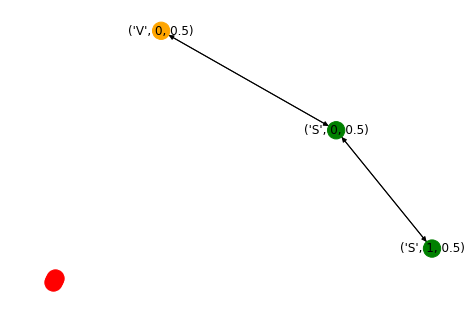

20 20 0


In [39]:
# Initialize game
from SNAPT_Game import SNAPT_Game as SNAPT

weights = [[1, 1, 0],
         [1, 1, 1],
         [0, 1, 1]]

m_atts = [[1, 0, 0.5, 0, 0],
          [0, 0, 0.5, 0, 0],
          [0, 1, 0.5, 0, 0]]

p1_atts = [1, 1, 1, 20, 1]
p2_atts = [1, 1, 1, 20, 1]

g = SNAPT(weights, m_atts, p1_atts, p2_atts)
board, player = g.getInitBoard()
g.render(board, player)

Get neural network inputs for attacker and defender

In [40]:
#TODO make more clear
attacker_inputs = len(g.get_attack_vector(board))
defender_inputs = len(g.get_defend_vector(board))

File names in ./checkpoint

In [41]:
filenames = ['a2c_att_pq_3600.pth.tar',                'a2c_def_pq_3600.pth.tar',
             'az_es_att_checkpoint.pth.tar',           'az_es_def_checkpoint.pth.tar',
             'az_grad_att_checkpoint.pth.tar',         'az_grad_def_checkpoint.pth.tar',
             'cem_att_pq_3600.pth.tar',                'cem_def_pq_3600.pth.tar',
             'oneone_att_pq_3600.pth.tar',             'oneone_def_pq_3600.pth.tar']


names = ['a2c', 'az_es', 'az_grad', 'cem', 'oneone', 'random']

Set up randomized attack agent which returns each action with uniform probability

In [42]:
class RandomAttackAgent():
    def __init__(self, g):
        self.g = g
        
    def forward(self, board):
        return torch.FloatTensor([1] * self.g.size), 0
    
class RandomDefenseAgent():
    def __init__(self, g):
        self.g = g
        
    def forward(self, board):
        return torch.FloatTensor([1] * (self.g.size*2)), 0

load all trained attacker networks

In [46]:
import os
from SNAPT_net import SNAPT_AC
import torch
from SNAPT_es import *
folder = 'checkpoint'


attacker_filenames = {
    'a2c' : 'a2c_att_pq_3600.pth.tar', 
    'az_es' : 'az_es_att_checkpoint.pth.tar', 
    'az_grad' : 'az_grad_att_checkpoint.pth.tar', 
    'cem' : 'cem_att_pq_3600.pth.tar', 
    'oneone' : 'oneone_att_pq_3600.pth.tar', 
}


attackers = {}

for attacker in attacker_filenames.keys():
    fname = attacker_filenames[attacker]
    loc = os.path.join(folder, fname)
    
    attackers[attacker] = SNAPT_AC(attacker_inputs, g.size, 64)
    checkpoint = torch.load(loc)
    if 'az' in fname:
        attackers[attacker].load_state_dict(checkpoint['state_dict'])
        
    else:
        attackers[attacker].load_state_dict(checkpoint)

attackers['random'] = RandomAttackAgent(g)

Load all trained defender networks

In [47]:
defender_filenames = {
    'a2c' : 'a2c_def_pq_3600.pth.tar', 
    'az_es' : 'az_es_def_checkpoint.pth.tar', 
    'az_grad' : 'az_grad_def_checkpoint.pth.tar', 
    'cem' : 'cem_def_pq_3600.pth.tar', 
    'oneone' : 'oneone_def_pq_3600.pth.tar', 
}


defenders = {}

for defender in defender_filenames.keys():
    fname = defender_filenames[defender]
    loc = os.path.join(folder, fname)
    
    defenders[defender] = SNAPT_AC(defender_inputs, 2 * g.size, 64)
    checkpoint = torch.load(loc)
    
    if 'az' in fname:
        defenders[defender].load_state_dict(checkpoint['state_dict'])
        
    else:
        defenders[defender].load_state_dict(checkpoint)

defenders['random'] = RandomDefenseAgent(g)

In [48]:
# total number of games for each pairing to play, original was 100
TOTAL_GAMES = 1

Play matches using only neural networks

In [49]:
wins = []
count = 0
for attacker_name in attackers.keys():
    attacker = attackers[attacker_name]
    print(attacker_name)
    count += 1
    attacker_wins = []
    for defender_name in defenders.keys():
        defender = defenders[defender_name]
        win_count = attacker_vs_defender(g, attacker, defender, TOTAL_GAMES, temp = 1)
        attacker_wins.append(win_count)
        print(win_count, end = ', ')
    print()
    wins.append(attacker_wins)


a2c
1, 0, 1, 0, 1, 1, 
az_es
1, 1, 0, 0, 0, 0, 
az_grad
1, 0, 0, 0, 0, 0, 
cem
1, 0, 0, 0, 1, 1, 
oneone
1, 0, 0, 0, 1, 0, 
random
0, 0, 0, 0, 1, 1, 


Store win counts as csv

In [50]:
import pandas as pd

nnet_wins = pd.DataFrame(wins, columns = names, index = names)

nnet_wins = nnet_wins.transpose()

nnet_wins.to_csv(r'nnet_wins.csv')

nnet_wins

,a2c,az_es,az_grad,cem,oneone,random
a2c,1,1,1,1,1,0
az_es,0,1,0,0,0,0
az_grad,1,0,0,0,0,0
cem,0,0,0,0,0,0
oneone,1,0,0,1,1,1
random,1,0,0,1,0,1


Play matches using Monte Carlo tree search



In [ ]:
from SNAPT_AZ import *
from SNAPT_net import NNetWrapper

args = dotdict({
    'numEps': 5,        # Number of complete self-play games to simulate during a new iteration.
    'numMCTSSims': 20,  # Number of games moves for MCTS to simulate.
    'cpuct': 1,         # hyperparameter for MCTS
    'batch_size' : 8,  # number of samples to take for AZ-ES, N in paper
    'elite_size' : 4,  # elite size for AZ-ES, K in paper
})

wins = []
count = 0

for attacker_name in attackers.keys():
    attacker = attackers[attacker_name]
    print(attacker_name)
    count += 1
    att_wins = []
    for defender_name in defenders.keys():
        defender = defenders[defender_name]
        nnet_wrapper = NNetWrapper(g)
        
        if type(attacker) != type(RandomAttackAgent(g)):
            nnet_wrapper.att_nnet = attacker
            
        if type(defender) != type(RandomDefenseAgent(g)):
            nnet_wrapper.def_nnet = defender
        
        mcts = MCTS(g, nnet_wrapper, args)
        AZ = AlphaZero(g, nnet_wrapper, mcts, args)
        win_count = 0
        
        # Execute given amount of AlphaZero self play games
        # does not train
        for _ in range(TOTAL_GAMES):
            if AZ.execute_episode(render = False)[-1] == 1:
                win_count += 1
                
        print(win_count, end = ', ')
        att_wins.append(win_count)
        
    print()
    wins.append(att_wins)

a2c
1, 0, 0, 0, 0, 0, 
az_es
0, 1, 0, 0, 

In [37]:
mcts_wins = pd.DataFrame(wins, columns = names, index = names)

mcts_wins = mcts_wins.transpose()

mcts_wins.to_csv(r'mcts_wins.csv')

mcts_wins

,a2c,az_es,az_grad,cem,oneone,random
a2c,0,0,0,0,0,1
az_es,1,0,0,1,0,0
az_grad,0,0,1,0,0,1
cem,0,0,1,0,0,1
oneone,0,1,1,0,0,0
random,0,0,1,1,0,0
